# Máy học nâng cao - Lab 03
# Họ tên: Nguyễn Phú Thành. MSSV: 18110014

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as keras_backend
from copy import deepcopy

In [2]:
class FullyConnectedLayer(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.units = units
    
    def build(self, input_shape):
        std = tf.math.sqrt(2/(input_shape[-1] + self.units))
        self.W = self.add_weight(
            name = "weights",
            shape = (input_shape[-1], self.units),
            initializer = tf.random_normal_initializer(mean = 0, stddev = std),
            trainable = True
        )
        self.b = self.add_weight(
            name = "bias",
            shape = (self.units,),
            initializer = tf.random_normal_initializer(mean = 0, stddev = std),
            trainable = True
        )
    
    def call(self, inputs):
        return tf.nn.relu(tf.matmul(inputs, self.W) + self.b)

In [3]:
class ConvMaxpoolBlock(tf.keras.layers.Layer):
    
    def __init__(self, filter_size, n_filters):
        super().__init__()
        self.filter_size = filter_size
        self.n_filters = n_filters

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name = "kernel",
            shape = (self.filter_size[0], self.filter_size[1], input_shape[-1], self.n_filters),
            initializer = tf.random_normal_initializer,
            trainable = True
        )
        
        self.bias = self.add_weight(
            name = "bias",
            shape = (1, self.n_filters),
            initializer=tf.random_normal_initializer,
            trainable = True
        )
    
    def call(self, inputs):
        conv = keras_backend.conv2d(
            x = inputs,
            kernel = self.kernel,
            padding = "same"
        )
        conv = conv + self.bias
        conv = tf.nn.relu(conv)
        maxpool = keras_backend.pool2d(
            conv, 
            pool_size = (2,2), 
            strides = (2,2),
            pool_mode = "max"
        )
        return maxpool

# Bài tập
1. Hãy tạo ra một block DoubleConvMaxpool gồm 2 lớp ConvMaxpool có số filters lần lượt là 16, 32, và một block DoubleFC có số hidden nodes lần lượt là 100, 50

In [4]:
class DoubleConvMaxpool(tf.keras.layers.Layer):
    def __init__(self, n_filters, filter_sizes):
        super().__init__()
        self.conv_max_1 = ConvMaxpoolBlock(filter_sizes[0], n_filters[0])
        self.conv_max_2 = ConvMaxpoolBlock(filter_sizes[1], n_filters[1])
    
    def build(self, input_shape):
        self.conv_max_1.build(input_shape)
        self.conv_max_2.build((self.conv_max_1.kernel.shape[-1],))
    
    def call(self, inputs):
        outputs_temp = self.conv_max_1.call(inputs)
        outputs = self.conv_max_2.call(outputs_temp)
        return outputs

In [5]:
class DoubleFullyConnected(tf.keras.layers.Layer):
    def __init__(self, n_units_1, n_units_2):
        super().__init__()
        self.FC_1 = FullyConnectedLayer(units = n_units_1)
        self.FC_2 = FullyConnectedLayer(units = n_units_2)
    
    def build(self, input_shape):
        self.FC_1.build(input_shape)
        self.FC_2.build((self.FC_1.units,))
    
    def call(self, inputs):
        outputs_temp = self.FC_1.call(inputs)
        outputs = self.FC_2.call(outputs_temp)
        return outputs

In [6]:
inputs = tf.keras.layers.Input(shape = (28, 28, 1))
double_conv_max_block = DoubleConvMaxpool(n_filters = (16, 32), filter_sizes = ((3, 3), (3, 3)))
outputs = double_conv_max_block(inputs)
print(outputs.shape)

(None, 7, 7, 32)


In [7]:
inputs = tf.keras.layers.Input(shape = (1000,))
double_fc = DoubleFullyConnected(n_units_1 = 100, n_units_2 = 50)
outputs = double_fc(inputs)
print(outputs.shape)

(None, 50)


2. Tạo ra model, train, và test trên tập mnist như hình bên dưới:
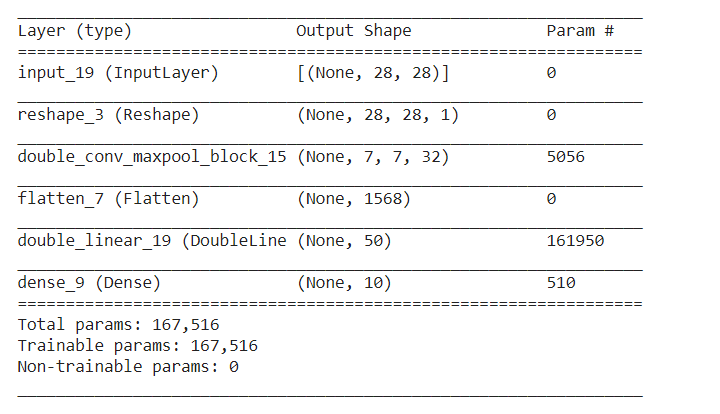

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float)/255.0, X_test.astype(np.float)/255.0
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

11501568/11490434 [==============================] - 0s 0us/step


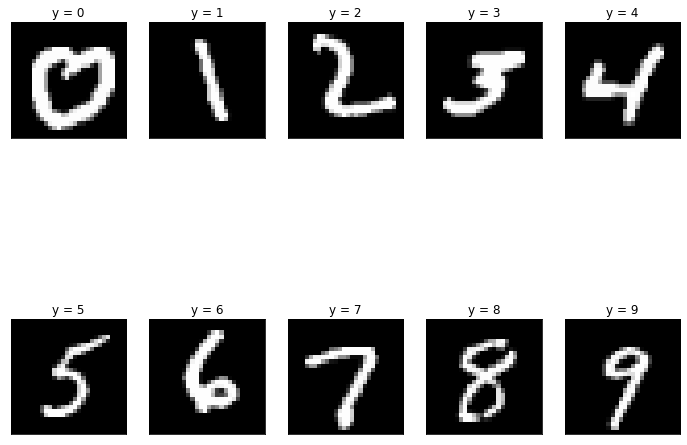

In [9]:
fig, axes = plt.subplots(figsize = (12, 10), nrows = 2, ncols = 5)
rnd = np.random.RandomState(0)
for label, ax in zip(np.unique(y_train), axes.flatten()):
    subset = X_train[(y_train == label).flatten()]
    index = rnd.choice(subset.shape)
    ax.imshow(subset[index - 1], cmap = plt.cm.gray)
    ax.set(title = f'y = {label}', xticks = [], yticks = [])
plt.show()

In [10]:
inputs = tf.keras.layers.Input(shape = (28, 28))
reshape = tf.keras.layers.Reshape(target_shape = (28, 28, 1))(inputs)
double_conv_max_block = DoubleConvMaxpool(n_filters = (16, 32), filter_sizes = ((5, 5), (3, 3)))(reshape)
flatten = tf.keras.layers.Flatten()(double_conv_max_block)
double_fc = DoubleFullyConnected(n_units_1 = 100, n_units_2 = 50)(flatten)
outputs = tf.keras.layers.Dense(units = 10, activation = tf.nn.softmax)(double_fc)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
double_conv_maxpool_1 (Doubl (None, 7, 7, 32)          5056      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
double_fully_connected_1 (Do (None, 50)                161950    
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 167,516
Trainable params: 167,516
Non-trainable params: 0
_______________________________________________________

In [11]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-2, momentum = 0.9, nesterov = True), 
    loss = tf.keras.losses.sparse_categorical_crossentropy, 
    metrics = ["accuracy",]
)

In [12]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_data = (X_valid, y_valid))

Epoch 1/10
211/211 [==============================] - 33s 14ms/step - loss: 1.0717 - accuracy: 0.6537 - val_loss: 0.2204 - val_accuracy: 0.9313
Epoch 2/10
211/211 [==============================] - 2s 12ms/step - loss: 0.1561 - accuracy: 0.9526 - val_loss: 0.1080 - val_accuracy: 0.9673
Epoch 3/10
211/211 [==============================] - 2s 12ms/step - loss: 0.0959 - accuracy: 0.9708 - val_loss: 0.0793 - val_accuracy: 0.9747
Epoch 4/10
211/211 [==============================] - 2s 12ms/step - loss: 0.0751 - accuracy: 0.9770 - val_loss: 0.0655 - val_accuracy: 0.9808
Epoch 5/10
211/211 [==============================] - 2s 12ms/step - loss: 0.0615 - accuracy: 0.9811 - val_loss: 0.0560 - val_accuracy: 0.9818
Epoch 6/10
211/211 [==============================] - 2s 11ms/step - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.0545 - val_accuracy: 0.9823
Epoch 7/10
211/211 [==============================] - 2s 12ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.0512 - val_accuracy: 0.982

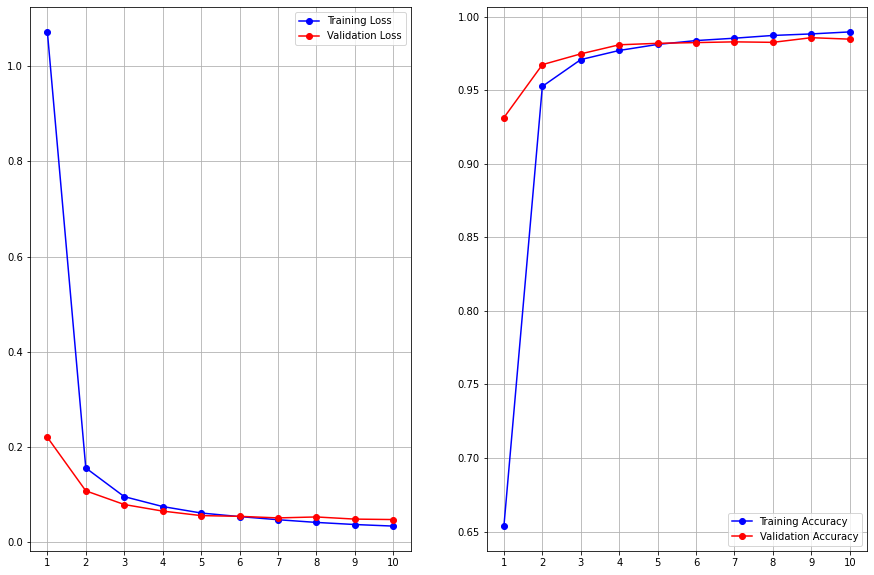

In [13]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10))
axes[0].plot(np.arange(1, 11), history.history['loss'], color = 'b', marker = 'o', label = 'Training Loss')
axes[0].plot(np.arange(1, 11), history.history['val_loss'], color = 'r', marker = 'o', label = 'Validation Loss')
axes[0].set(xticks = np.arange(1, 11))
axes[0].grid(True)
axes[0].legend()

axes[1].plot(np.arange(1, 11), history.history['accuracy'], color = 'b', marker = 'o', label = 'Training Accuracy')
axes[1].plot(np.arange(1, 11), history.history['val_accuracy'], color = 'r', marker = 'o', label = 'Validation Accuracy')
axes[1].set(xticks = np.arange(1, 11))
axes[1].grid(True)
axes[1].legend(loc = "lower right")

**Nhận xét:** Tại epoch cuối cùng, do accuracy trên validation và train đều cao nên mô hình không bị underfit. Hơn nữa, tại epoch này, loss và accuracy giữa tập validation và tập train không sai khác đáng kể nên mô hình không bị overfit. Như vậy, ta chọn tham số tại cuối thời điểm train cho mô hình

In [14]:
# Kiễm tra trên tập test
result = model.evaluate(X_test, y_test, verbose = 0)
print(f"Loss trên tập test là: {result[0]}. Accuracy trên tập test là: {result[1]}")

Loss trên tập test là: 0.04251720383763313. Accuracy trên tập test là: 0.9848999977111816
